# Extracting Emails from Gmail Account

In [1]:
import imaplib
import email
import traceback


ORG_EMAIL = "@gmail.com" 
FROM_EMAIL = "Your_Email" + ORG_EMAIL 
FROM_PWD = "Your_Password"  
SMTP_SERVER = "imap.gmail.com" 
SMTP_PORT = 993

def read_email_from_gmail():
    dataset = []  # List to store email data

    try:
        mail = imaplib.IMAP4_SSL(SMTP_SERVER)
        
        mail.login(FROM_EMAIL, FROM_PWD)
        
        mail.select('inbox')

        data = mail.search(None, 'ALL')
        mail_ids = data[1]
        id_list = mail_ids[0].split()   
        first_email_id = int(id_list[0])
        latest_email_id = int(id_list[-1])

        for i in range(latest_email_id, first_email_id, -1):
            data = mail.fetch(str(i), '(RFC822)' )
            for response_part in data:
                arr = response_part[0]
                if isinstance(arr, tuple):
                    msg = email.message_from_string(str(arr[1],'utf-8'))
                    email_subject = msg['subject']
                    email_from = msg['from']
                    
                    # Extracting the full email text
                    email_text = ''
                    for part in msg.walk():
                        if part.get_content_type() == 'text/plain':
                            email_text = part.get_payload(decode=True).decode('utf-8', 'ignore')
                            break
                    
                    dataset.append({
                        'From': email_from,
                        'Subject': email_subject,
                        'Text': email_text
                    })

    except Exception as e:
        traceback.print_exc() 
        print(str(e))

    return dataset

emails_dataset = read_email_from_gmail()


import pandas as pd

df = pd.DataFrame(emails_dataset)
df.to_csv('emails_dataset.csv', index=False)


In [2]:
email = pd.read_csv("emails_dataset.csv")
email

,From,Subject,Text
0,Google <no-reply@accounts.google.com>,Security alert,[image: Google]\r\nApp password created to sig...
1,Google <no-reply@accounts.google.com>,2-Step Verification turned on,[image: Google]\r\n2-Step Verification turned ...
2,Google <no-reply@accounts.google.com>,Security alert,[image: Google]\r\nPhone number added for 2-St...
3,Google <no-reply@accounts.google.com>,Security alert,[image: Google]\r\nA new sign-in on Windows\r\...
4,YouTube <no-reply@youtube.com>,=?UTF-8?Q?Annual_reminder_about_YouTube=E2=80=...,This email is an annual reminder that your use...
...,...,...,...
67,000webhost <clients@000webhost.com>,Achieve more with Power Store,Enter your TEXT content here\r\n
68,donot_reply@onlinedegree.iitm.ac.in,IITM BSc Degree - Fees for Qualifier exam yet ...,NaN
69,"""000webhost.com"" <clients@000webhost.com>",Your website awaits!,\r\n
70,000webhost <clients@000webhost.com>,Have you started your website? =?utf-8?Q?=F0=9...,\r\n


# Labelling of Extracted Emails using NLP(Spam or Ham)

Create Bag-of-Words Representation:

Utilizes CountVectorizer to convert the preprocessed text data into a bag-of-words representation (X).

Create Gensim Dictionary and Corpus:

Creates a Gensim Dictionary (gensim_dict) and a Gensim Corpus (corpus) from the preprocessed documents.

Apply LDA (Topic Modeling):

Defines the number of topics (num_topics) and applies LDA using Gensim's LdaModel.
The resulting model is stored in lda_model.

Get Topics for Each Document:

Applies the trained LDA model to each document in the dataset and stores the topics for each document in a new column called 'Topics' in the DataFrame.

Display Results:

Iterates through the DataFrame and prints the document index along with the corresponding topics assigned by the LDA model.

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Load the dataset
df = pd.read_csv('emails_dataset.csv')

# Handle missing values in the 'Text' column
df['Text'].fillna('', inplace=True)

documents = df['Text'].tolist()

# Text preprocessing
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, str):  
        text = text.lower()
        text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

documents = [preprocess_text(doc) for doc in documents]

# Create a Bag-of-Words representation
vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)

# Create a Gensim Dictionary from the documents
gensim_dict = Dictionary([doc.split() for doc in documents])

# Create a Gensim Corpus
corpus = [gensim_dict.doc2bow(doc.split()) for doc in documents]

# Apply LDA
num_topics = 2 
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=gensim_dict, passes=15)

# Get the topics for each document
df['Topics'] = [lda_model.get_document_topics(gensim_dict.doc2bow(doc.split())) for doc in documents]

# Display the results
for index, row in df.iterrows():
    print(f"Email {index + 1} Topics: {row['Topics']}")


Email 1 Topics: [(0, 0.9893469), (1, 0.010653081)]
Email 2 Topics: [(0, 0.99231523)]
Email 3 Topics: [(0, 0.99049497)]
Email 4 Topics: [(0, 0.98981756), (1, 0.010182445)]
Email 5 Topics: [(1, 0.99587286)]
Email 6 Topics: [(0, 0.5), (1, 0.5)]
Email 7 Topics: [(0, 0.5), (1, 0.5)]
Email 8 Topics: [(0, 0.9983421)]
Email 9 Topics: [(0, 0.5), (1, 0.5)]
Email 10 Topics: [(0, 0.5), (1, 0.5)]
Email 11 Topics: [(0, 0.5), (1, 0.5)]
Email 12 Topics: [(0, 0.9936357)]
Email 13 Topics: [(0, 0.5), (1, 0.5)]
Email 14 Topics: [(0, 0.5), (1, 0.5)]
Email 15 Topics: [(0, 0.5), (1, 0.5)]
Email 16 Topics: [(0, 0.5), (1, 0.5)]
Email 17 Topics: [(0, 0.5), (1, 0.5)]
Email 18 Topics: [(0, 0.5), (1, 0.5)]
Email 19 Topics: [(0, 0.5), (1, 0.5)]
Email 20 Topics: [(0, 0.5), (1, 0.5)]
Email 21 Topics: [(0, 0.5), (1, 0.5)]
Email 22 Topics: [(0, 0.5), (1, 0.5)]
Email 23 Topics: [(0, 0.5), (1, 0.5)]
Email 24 Topics: [(0, 0.5), (1, 0.5)]
Email 25 Topics: [(0, 0.5), (1, 0.5)]
Email 26 Topics: [(0, 0.5), (1, 0.5)]
Email 27 

In [4]:
# Set a threshold for spam probability
spam_threshold = 0.8

# Create a new column 'Label' based on the threshold
df['Label'] = df['Topics'].apply(lambda topics: 'spam' if any(prob > spam_threshold for _, prob in topics) else 'ham')

# Drop the old 'Spam' column if needed
df = df.drop(columns=['Spam'], errors='ignore')

# Display the results
for index, row in df.iterrows():
    print(f"Email {index + 1} - Label: {row['Label']}")

# Save the DataFrame with the new 'Label' column
df.to_csv('result_dataset.csv', index=False)


Email 1 - Label: spam
Email 2 - Label: spam
Email 3 - Label: spam
Email 4 - Label: spam
Email 5 - Label: spam
Email 6 - Label: ham
Email 7 - Label: ham
Email 8 - Label: spam
Email 9 - Label: ham
Email 10 - Label: ham
Email 11 - Label: ham
Email 12 - Label: spam
Email 13 - Label: ham
Email 14 - Label: ham
Email 15 - Label: ham
Email 16 - Label: ham
Email 17 - Label: ham
Email 18 - Label: ham
Email 19 - Label: ham
Email 20 - Label: ham
Email 21 - Label: ham
Email 22 - Label: ham
Email 23 - Label: ham
Email 24 - Label: ham
Email 25 - Label: ham
Email 26 - Label: ham
Email 27 - Label: ham
Email 28 - Label: spam
Email 29 - Label: ham
Email 30 - Label: ham
Email 31 - Label: ham
Email 32 - Label: ham
Email 33 - Label: ham
Email 34 - Label: ham
Email 35 - Label: ham
Email 36 - Label: ham
Email 37 - Label: ham
Email 38 - Label: ham
Email 39 - Label: ham
Email 40 - Label: ham
Email 41 - Label: ham
Email 42 - Label: ham
Email 43 - Label: ham
Email 44 - Label: ham
Email 45 - Label: ham
Email 46 - 

# Model Training using extracted Emails

In [11]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Load data
data = pd.read_csv('result_dataset.csv')
data.columns = ['From', 'Subject', 'Text', 'Topics', 'Label']

# Check for NaN values in the 'Text' column and replace them with an empty string
data["Text"] = data["Text"].fillna("")

# Apply the len function only to non-null and non-float values
data["length"] = data["Text"].apply(lambda x: len(str(x)) if not isinstance(x, float) else 0)

In [12]:
data

,From,Subject,Text,Topics,Label,length
0,Google <no-reply@accounts.google.com>,Security alert,[image: Google]\r\nApp password created to sig...,"[(0, 0.9893469), (1, 0.010653081)]",spam,683
1,Google <no-reply@accounts.google.com>,2-Step Verification turned on,[image: Google]\r\n2-Step Verification turned ...,"[(0, 0.99231523)]",spam,911
2,Google <no-reply@accounts.google.com>,Security alert,[image: Google]\r\nPhone number added for 2-St...,"[(0, 0.99049497)]",spam,728
3,Google <no-reply@accounts.google.com>,Security alert,[image: Google]\r\nA new sign-in on Windows\r\...,"[(0, 0.98981756), (1, 0.010182445)]",spam,699
4,YouTube <no-reply@youtube.com>,=?UTF-8?Q?Annual_reminder_about_YouTube=E2=80=...,This email is an annual reminder that your use...,"[(1, 0.99587286)]",spam,4115
...,...,...,...,...,...,...
67,000webhost <clients@000webhost.com>,Achieve more with Power Store,Enter your TEXT content here\r\n,"[(0, 0.12719232), (1, 0.8728077)]",spam,30
68,donot_reply@onlinedegree.iitm.ac.in,IITM BSc Degree - Fees for Qualifier exam yet ...,,"[(0, 0.5), (1, 0.5)]",ham,0
69,"""000webhost.com"" <clients@000webhost.com>",Your website awaits!,\r\n,"[(0, 0.5), (1, 0.5)]",ham,2
70,000webhost <clients@000webhost.com>,Have you started your website? =?utf-8?Q?=F0=9...,\r\n,"[(0, 0.5), (1, 0.5)]",ham,2


In [13]:
data.describe()

,length
count,72.000000
mean,237.958333
std,774.377068
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,4291.000000


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

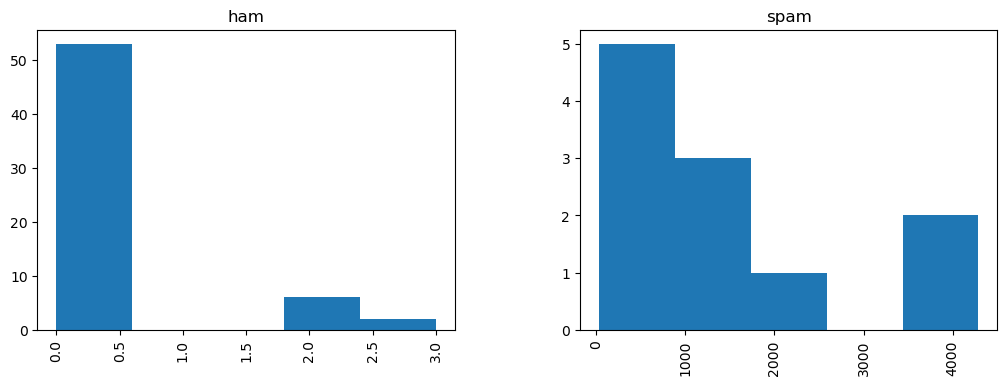

In [14]:
    data.hist(column = 'length', by ='Label',figsize=(12,4), bins = 5)

In [15]:
# Tokenization and Stopword Removal
stop_words = set(stopwords.words('english'))

def transform_message(message):
    message = ''.join([char for char in message if char not in string.punctuation])
    message_clean = [word for word in message.split() if word.lower() not in stop_words]
    return ' '.join(message_clean)

# Vectorization and TF-IDF
text_clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=transform_message)),
    ('tfidf', TfidfTransformer())
])

X = text_clf.fit_transform(data['Text'])
y = data['Label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=50)

# Train the SVC model
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Test the model
predictions = clf.predict(X_test)
print('Classification Report:\n', classification_report(y_test, predictions))
print('Confusion Matrix:\n', confusion_matrix(y_test, predictions))


Classification Report:
               precision    recall  f1-score   support

         ham       1.00      1.00      1.00        20
        spam       1.00      1.00      1.00         2

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Confusion Matrix:
 [[20  0]
 [ 0  2]]


# Testing Model

In [16]:
print(confusion_matrix(y_test,predictions))

[[20  0]
 [ 0  2]]


In [17]:
predictions = clf.predict(X_test)
print('predicted', predictions)

predicted ['ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam']


In [18]:
print (classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00        20
        spam       1.00      1.00      1.00         2

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



# Save the SVC Model

In [19]:
import joblib

joblib.dump(clf, 'spam_classifier_model.joblib')


['spam_classifier_model.joblib']